In [1]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

print(f"GPU Available: {torch.cuda.get_device_name(0)}")

# Check PyTorch version
print("Torch Version", torch.__version__)

GPU Available: NVIDIA GeForce RTX 4050 Laptop GPU
Torch Version 2.8.0+cu128


### Creating a simple dataset using the linear regression formula

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02

x = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * x + bias

# x[:10], y[:10]

In [3]:
# len(x), len(y)

### Splitting data into training and test sets

In [4]:
# Create a train/test split
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]
len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

### Exploring data

In [5]:
def plot_predictions(
    train_data=x_train,
    train_labels=y_train,
    test_data=x_test,
    test_labels=y_test,
    predictions=None,
    ):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, s=4, c="b", label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, s=4, c="g", label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exists
        plt.scatter(test_data, predictions, s=4, c="r", label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

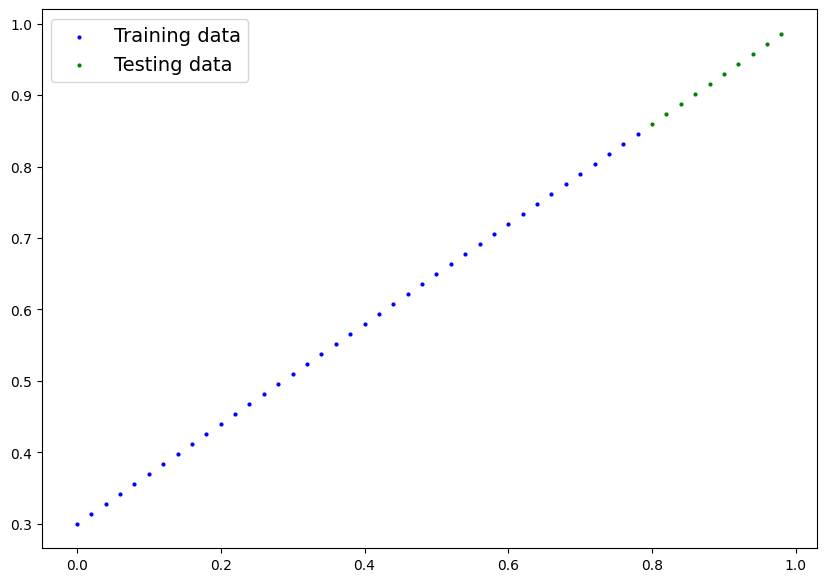

In [6]:
plot_predictions()

### Building first PyTorch model!
 * start with randon values (weight & bias)
 * look at the training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data)


How does it do so?
Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
import torch
from torch import nn

# Create a linerar regression model class
class LinearRegressionModel(
    nn.Module  # <- nn.Module contains all the building blocks for neural network
):  # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # Initalize model parameters
        self.weight = nn.Parameter(
            torch.randn(
                1,  # <- start with a random weight and try to adjust it to the ideal weight
                requires_grad=True,  # <- can this parameter be updated via gradient descent?
                dtype=torch.float32,  # PyTorch loves the datatype torch.float32
            )
        )  # <- PyTorch loves the datatype torch.float32

        self.bias = nn.Parameter(
            torch.randn(
                1,  # <- start with a random bias and try to adjust it to the ideal bias
                requires_grad=True,  # <- can this parameter be updated via gradient descent?
                dtype=torch.float32,  # PyTorch loves the datatype torch.float32
            )
        )

    # Forward method to define the computation in the model, all subclasses of nn.Module need to overwrite forward method.
    # This defines the forward computation of the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # <- "x" is the input data
        return self.weight * x + self.bias  # this is the linear regression formula

### PyTorch model building essentials

1. **torch.nn** - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)

2. **torch.nn.Parameter** - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.

3. **torch.nn.Module** - The base class for all neural network modules, if you subclass it, you should overwrite forward()

4. **torch.optim** - this where the optimizers in PyTorch live, they will help with gradient descent

5. **def forward()** - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (the model is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Checkout out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List names parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `x_test`.

When we pass data through our mode, it's going it through the forward() method.

In [10]:
x_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [11]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(x_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

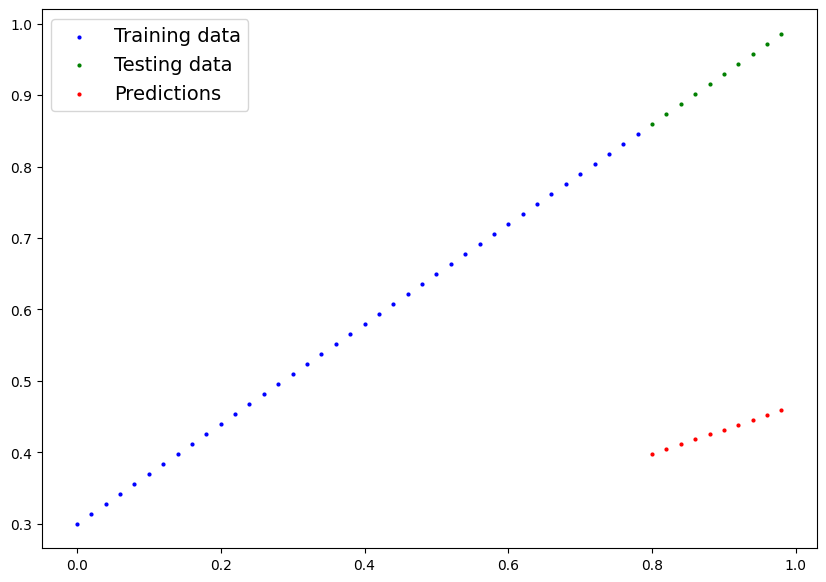

In [12]:
plot_predictions(predictions=y_preds)

### 3. Train model

The whole idea of training is for a model to move from some *unknown* parameterrs (these may be random) to some *known* parameters.

or in other words from a poor representation of the data to a better representation of the data.

One ways to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower it better.

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optiomizer (stochastic gradient descent)
optimizer = torch.optim.SGD(
    params=model_0.parameters(), lr=0.01
)

### Building a training loop (and a testing toop) in PyTorch

A coupple of things we need in a training loop:
0. Loop through the data and do...
1. forward pass (this involves data moving through our model's `forward()` functions) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respest to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [16]:
# An epoch is one loop through the data...(this is a hyperparameter because we've set it ourselves)
epochs = 170

# Track different values
epoch_count = []
train_loss = []
train_loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()  # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_preds = model_0(x_train)

    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()  # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

    # Testing works with test data, training works with training data
    model_0.eval()  # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers).

    # Make predictions after training
    with torch.inference_mode():  # turns off gradient tracking & a couple of more things behing thr scenes that are not needed for evaluation/testing
        # 1. Do the forward pass
        test_pred = model_0(x_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
 
    # print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

/tmp/ipykernel_191154/2809378878.py:2: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label="Train loss")


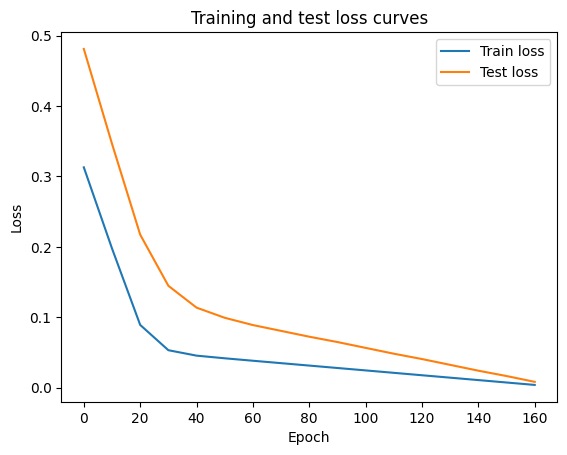

In [17]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title('Training and test loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format.
2. `torch.load()` - allows you to load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` -  this allows to load a model's saved state dictionary

In [18]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


### Loading a PyTorch model
Since we save our model's state_dict() rather than the entire mode, we'll create a new instance of our model class and load the saved state_dict() into that.

In [19]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [20]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [22]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(x_test)
    
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [23]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(x_test)
    
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together
Let's go back through the steps above and see it all in one place.

In [24]:
# Import Pytorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.8.0+cu128'

##### Create device-agnostic code.
This means if we got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [25]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [26]:
# Create some data using the linear regression formula of y = weight * x + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create x and y (features and labels)

x = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will popup
y = weight * x + bias

x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

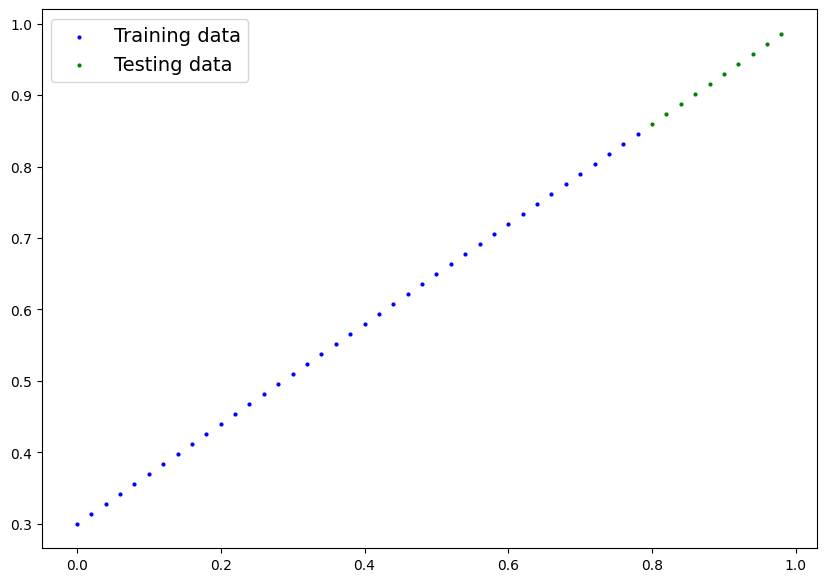

In [27]:

# Split data
train_split = int(.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]
len(x_train), len(y_train), len(x_test), len(y_test)

plot_predictions(x_train, y_train, x_test, y_test)

### Building a PyTorch Linear Model

In [28]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [29]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [30]:
# Set the model to use the target device
device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training
For training we need
* Loss function
* Optimizer
* Training loop
* Testing loop

In [31]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [32]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    # 1. Forward pass
    y_preds = model_1(x_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(x_test)
        
        test_loss = loss_fn(test_pred, y_test)
        
        # Print out what's happening
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [33]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [34]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [35]:
# Turn model in evaluation mode
model_1.eval()

# Makde predictions on the test data
with torch.inference_mode():
    y_preds = model_1(x_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

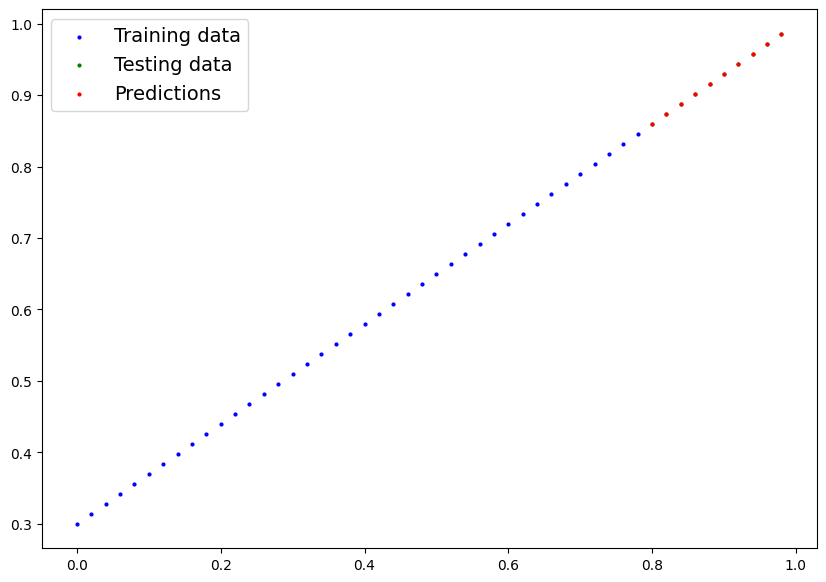

In [36]:
# Checkout our model predictions visually
plot_predictions(predictions=y_preds.cpu())

In [37]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 2. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [38]:
# Load a PyTorch

# Create a new instance of linear regressing model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [39]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [40]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [41]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(x_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')